In [266]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

### 1 Linear Regression
*  Implement a simple linear regression on a synthetic problem you construct. This can be achieved by generating covariates from a random number generator in a design matrix X 2 RN ⇥p, for suitable values of N and p, defining a set of weights w⇤ 2 Rp, again at random, constructing target data by the product X w⇤. It is usual to corrupt the product by adding a small amount of noise to it to simulate how measurements are made in the real world.
* On such a synthetic dataset, implement: (i) linear regression estimated in closed form; (ii) linear regression estimated by gradient descent; and (iii) linear regression estimated using stochastic gradient descent. Show in a graph the scatter of predicted and true targets and the learning curves for the gradient descent solutions. Graphs you obtain will be similar to those shown in Figs. 1 and 2.
* With stochastic learning, note that the learning curve looks noisy and does not converge to a fixed answer. In Fig. 2(b), for example, between iterations 250 and 2000, where we decide to stop will return answers that di↵er in error by about 20. Why does this happen? Implement a method to avoid this and return a more consistent answer.
* pseudo_inverse
* gradient_descent
* SGD

In [318]:
class LR:
    def pseudo_inverse(self, X, y):
        W_hat = np.linalg.inv(X.T@X)@X.T@y
        y_pi = X@W_hat
        error = np.linalg.norm(y_pi - y)
        return y_pi, error, W_hat
    
    def gradient_descent(self, X, y, p, MaxIter = 150, LR = 0.0001):
        W0 = np.random.randn(p, 1)
        W_g = W0
        Eplot = np.zeros((MaxIter,1))
        for iter in range(MaxIter):
            W_g = W_g - LR*X.T@(X@W_g - y)
            Eplot[iter] = np.linalg.norm(X @ W_g - y)
        return Eplot, W_g
    
    def SGD(self, X, y,lam=0.5, MaxIter = 2000, LR = 0.05):
        N, p = len(X), len(X[0])
        # True parameters
        #
        w0 = np.random.randn(p,1)
        E0 = np.linalg.norm(y - X @ w0) 
        print(E0)
        Eplot = np.zeros((MaxIter, 1))
        wIter= w0
        for iter in range(MaxIter):
            j = np.floor(np.random.rand()*N).astype(int) 
            xj = X[j,:]
            xj = np.array([X[j,:]]).T
            yj = y[j,:]
            yPred = xj.T @ wIter
            wIter = wIter - LR * (yPred-yj) * xj
            Eplot[iter] = np.linalg.norm(y - X @ wIter)
        return Eplot, wIter



In [319]:
N, p = 500, 30
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8*np.random.randn(N, 1)
y = X@W_True + noise

Residual Error (Initial) : 167.96
Residual Error (Converged): 17.05
Residual Error: 17.05


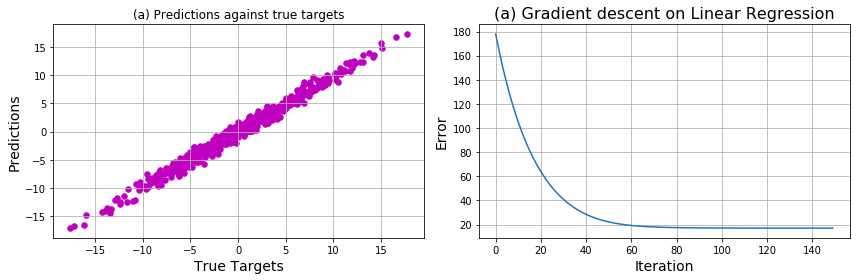

In [320]:
#Estimate in pseudo inverse
lr = LR() 
y_pi, error, W_hat = lr.pseudo_inverse(X,y)
        

#Scatter plot of predictions against truth
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 4))
ax[0].scatter(y, y_pi, c='m', s=30)
ax[0].grid(True)
ax[0].set_xlabel("True Targets", fontsize=14) 
ax[0].set_ylabel("Predictions", fontsize=14)
ax[0].set_title("(a) Predictions against true targets")
# GD
W0 = np.random.randn(p, 1)
E0 = np.linalg.norm(y - X @ W0)
lr = LR()

Eplot, W_g = lr.gradient_descent(X, y, p)

plt.tight_layout()
ax[1].plot(Eplot) 
ax[1].set_xlabel("Iteration", fontsize=14) 
ax[1].set_ylabel("Error", fontsize=14) 
ax[1].grid(True)
ax[1].set_title("(a) Gradient descent on Linear Regression", fontsize=16)

print("Residual Error (Initial) : %3.2f" %(E0)) 
print("Residual Error (Converged): %3.2f"%(np.linalg.norm(X @ W_g - y)))

plt.tight_layout()
print("Residual Error: %3.2f" %(np.linalg.norm(y_pi - y)))
plt.tight_layout()
plt.savefig('LR_pi_gd.png')

145.22845456472817
36.17826499828401
139.6570940402159
18.340765553352345


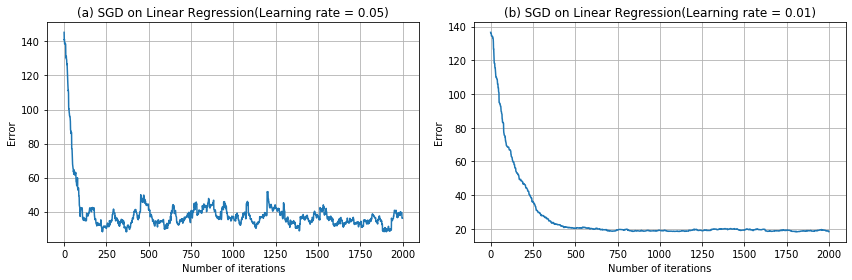

In [321]:
#Estimate by gradient descent
#initial guess and error


#Estimate by stochastic gradient descent
N, p = 500, 30
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
y = X @ W_True + noise
#initial guess and error
lr = LR()
Eplot, W_sg = lr.SGD(X, y, p, LR=0.05)


print(np.linalg.norm(y - X @ W_sg)) 
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Eplot[:2000])
ax[0].set_xlabel("Number of iterations") 
ax[0].set_ylabel("Error")
ax[0].grid(True)
ax[0].set_title("(a) SGD on Linear Regression(Learning rate = 0.05)") 
lr = LR()
Eplot, W_sg = lr.SGD(X, y, p, LR=0.01)


print(np.linalg.norm(y - X @ W_sg)) 

ax[1].plot(Eplot[:2000])
ax[1].set_xlabel("Number of iterations") 
ax[1].set_ylabel("Error")
ax[1].grid(True)
ax[1].set_title("(b) SGD on Linear Regression(Learning rate = 0.01)") 
plt.tight_layout()
plt.savefig("LR_GD_SGD.png")


### Recursive Least Squares
* Implement your own Recursive Least Squares solution and show how error reduces as a function of iteration.

In [322]:
class RLS:
    def __init__(self, p, lam, eps = 0.1, w = 'random'):
        self.p = p
        self.lam = lam
        self.eps = eps
        if w == 'random':
            self.w = np.random.randn(p,1) 
        else:
            self.w = np.zeros(p,1) 
        self.P = 1/self.eps * np.identity(p)
        
    def run(self, y, X):
        N = len(X)
        self.p = len(X[0])
        Y = np.zeros(N)
        e = np.zeros(N)
        self.w_history = np.zeros((N, self.p))
        for i in range(N):
            self.w_history[i,:] = self.w.reshape(1,p)
            x = X[i,:].reshape(1,p)
            Y[i] = x @ self.w
            e[i] = y[i] - Y[i]
            k = self.P @ x.T / (self.lam + x @ self.P @ x.T)
            self.P = (self.P - k @ x @ self.P) / self.lam
            self.w = self.w + k * e[i]
        return Y, e, self.w_history
    


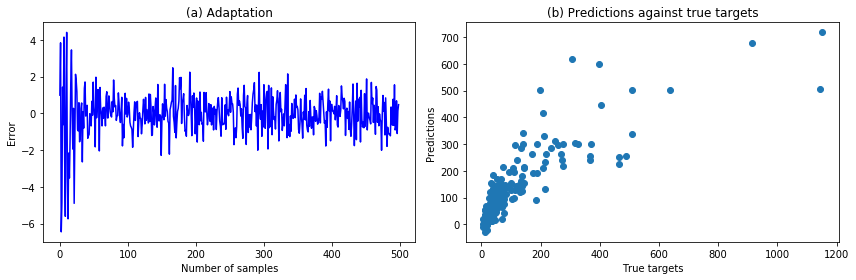

In [346]:
N, p = 500, 20
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
Y = X @ W_True + noise
rls = RLS(p, 0.99, w = 'random')
y, e, w = rls.run(Y, X)

fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].set_title("(a) Adaptation")
ax[0].set_xlabel("Number of samples")
ax[0].set_ylabel("Error")
ax[0].plot(e[1:],"b")
ax[1].scatter(Y_, y_pred)
ax[1].set_title("(b) Predictions against true targets")
ax[1].set_xlabel('True targets')
ax[1].set_ylabel('Predictions')
plt.tight_layout()
plt.savefig('RLS_self.png')

### Trend / relationship between the speed of convergence and the dimensionality of the problem
* Is there a trend / relationship between the speed of convergence and the dimensionality of the problem?
* The higher the dimension, the longer it will take to converge

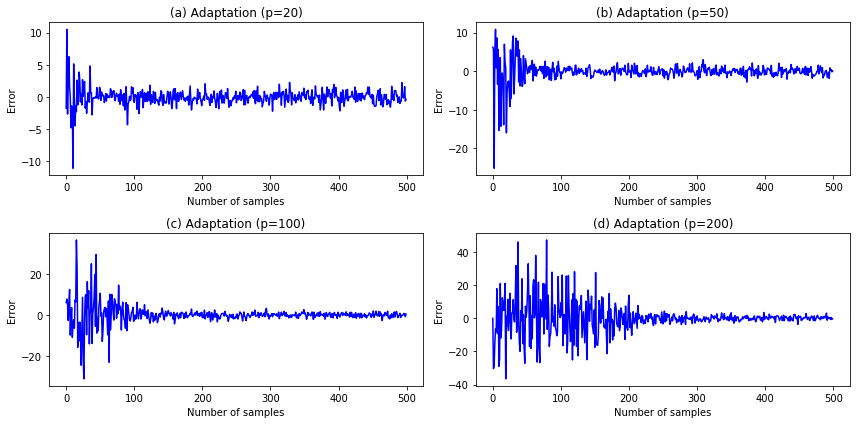

In [324]:
fig, ax = plt.subplots(2,2, figsize = (12,6))
N = 500

p = 20
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
Y = X @ W_True + noise
rls = RLS(p, 0.99, w = 'random')
y, e, w = rls.run(Y, X)

ax[0][0].set_title("(a) Adaptation (p="+str(p)+")")
ax[0][0].set_xlabel("Number of samples")
ax[0][0].set_ylabel("Error")
ax[0][0].plot(e,"b")

p = 50
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
Y = X @ W_True + noise
rls = RLS(p, 0.99, w = 'random')
y, e, w = rls.run(Y, X)

ax[0][1].set_title("(b) Adaptation (p="+str(p)+")")
ax[0][1].set_xlabel("Number of samples")
ax[0][1].set_ylabel("Error")
ax[0][1].plot(e,"b")

p = 100
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
Y = X @ W_True + noise
rls = RLS(p, 0.99, w = 'random')
y, e, w = rls.run(Y, X)

ax[1][0].set_title("(c) Adaptation (p="+str(p)+")")
ax[1][0].set_xlabel("Number of samples")
ax[1][0].set_ylabel("Error")
ax[1][0].plot(e,"b")

p = 200
X = np.random.randn(N, p)
W_True = np.random.randn(p,1)
noise = 0.8 * np.random.randn(N, 1)
Y = X @ W_True + noise
rls = RLS(p, 0.99, w = 'random')
y, e, w = rls.run(Y, X)

ax[1][1].set_title("(d) Adaptation (p="+str(p)+")")
ax[1][1].set_xlabel("Number of samples")
ax[1][1].set_ylabel("Error")
ax[1][1].plot(e,"b")
plt.tight_layout()
plt.savefig("Convergence.png")


### UCI data set RUSSELL data
* Download a dataset from the UCI Machine Learning Repository (https://archive.ics. uci.edu/ml/index.php). Compare the learning curves of stochastic gradient descent and recursive least squares on this problem.
* https://archive.ics.uci.edu/ml/datasets/Computer%2BHardware

In [325]:

'''
1. vendor name: 30
(adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec,
dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson,
microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry,
sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

'''
df = pd.read_table("machine.data",sep=',', names=['vendor_name','Model_Name','MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP','ERP'])
Y = np.array(df['PRP'])
data = np.array(df[df.columns[2:-1]])
X_ = data[:,:-1]
Y_ = data[:,-1]
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)
X = data[:,:-1]
Y = data[:,-1]

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.


R2_score:  0.8207720264098965


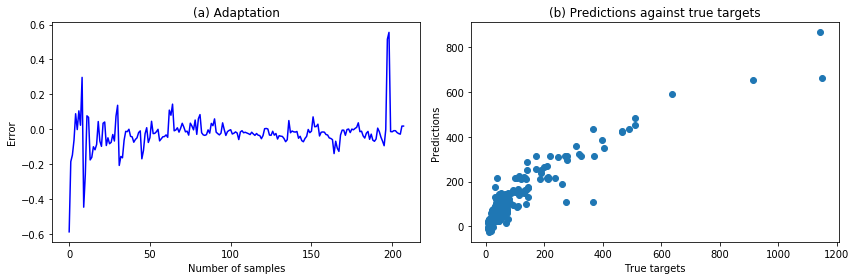

In [326]:
#Using RLS

N = len(X)
p = len(X[0])
rls = RLS(p, 0.999, w = 'random')
y, e, w = rls.run(Y, X)
y_pred = scaler.inverse_transform(np.concatenate((X,(X@w[-1,:]).reshape(N,1)), axis=1))[:,-1]
print("R2_score: ", r2_score(Y_,y_pred))
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].set_title("(a) Adaptation")
ax[0].set_xlabel("Number of samples")
ax[0].set_ylabel("Error")
ax[0].plot(e[1:],"b")
ax[1].scatter(Y_, y_pred)
ax[1].set_title("(b) Predictions against true targets")
ax[1].set_xlabel('True targets')
ax[1].set_ylabel('Predictions')
plt.tight_layout()
plt.savefig("UCI_RLS.png")


R2_score:  0.7355017976436816


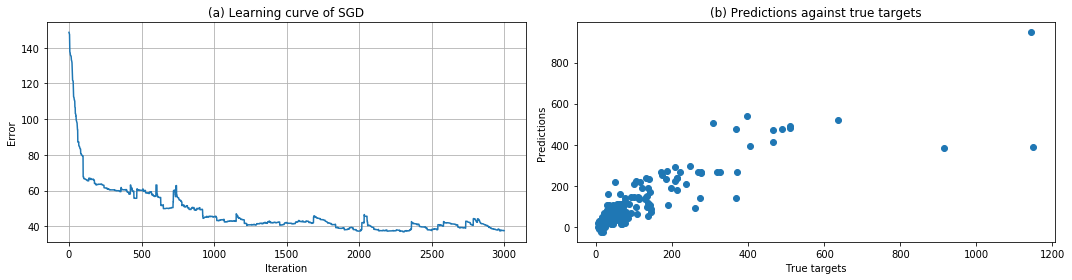

In [327]:

N = len(X)
p = len(X[0])
w0 = np.random.randn(p,1)
E0 = np.linalg.norm(Y - X @ w0) 
MaxIter = 3000
lRate = 0.1
Eplot = np.zeros((MaxIter, 1))
wIter= w0
for iter in range(MaxIter):
    j = np.floor(np.random.rand()*N).astype(int) 
    xj = X[j,:]
    xj = np.array([X[j,:]]).T
    yj = Y[j]
    yPred = xj.T @ wIter
    wIter = wIter - lRate * (yPred - yj) * xj 
    Eplot[iter] = np.linalg.norm(Y - X @ wIter)


fig, ax = plt.subplots(1,2, figsize = (15,4))
ax[0].plot(Eplot)
ax[0].set_xlabel("Iteration") 
ax[0].set_ylabel("Error")
ax[0].grid(True)
ax[0].set_title("(a) Learning curve of SGD") 
y_pred = scaler.inverse_transform(np.concatenate((X,(X@wIter)), axis=1))[:,-1]
ax[1].scatter(Y_, y_pred)
ax[1].set_title("(b) Predictions against true targets")
ax[1].set_xlabel('True targets')
ax[1].set_ylabel('Predictions')
print("R2_score: ", r2_score(Y_, y_pred))
plt.tight_layout()
plt.savefig("UCI_SGD.png")

### Implementation of the RLS algorithm in a software toolbox
* pandasip
* Find an implementation of the RLS algorithm in a software toolbox. MATLAB’s Signal Processign toolbox, Python packages statsmodels and Padasip are possibilities. Compare your results on one of the above tasks with that from the implementation in the toolbox.

No handles with labels found to put in legend.


R2_score:  0.6849241547474705


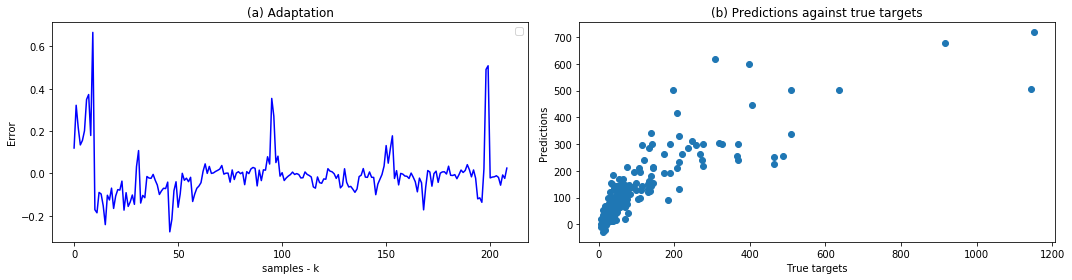

In [328]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 


p = len(X[0])
# identification
f = pa.filters.FilterRLS(n=p, mu=0.9, w="random")
y, e, w = f.run(Y, X)
y_pred = scaler.inverse_transform(np.concatenate((X,(X@w[-1,:]).reshape(N,1)), axis=1))[:,-1]
ax[1].scatter(Y_, y_pred)
print("R2_score: ", r2_score(Y_, y_pred))
# show results

fig, ax = plt.subplots(1,2, figsize = (15,4))
ax[0].set_title("(a) Adaptation")
ax[0].set_xlabel("samples - k")
ax[0].set_ylabel("Error")
ax[0].plot(e,"b")
ax[0].legend()
ax[1].scatter(Y_, y_pred)
ax[1].set_title("(b) Predictions against true targets")
ax[1].set_xlabel('True targets')
ax[1].set_ylabel('Predictions')
plt.tight_layout()
plt.savefig("RLS_Pandasip.png")  

### Option task: adaptive noise cancellation
* We considered adaptive noise cancellation as an example of online learning. The example il- lustrated in class used the Least Mean Squares (LMS) algorithm for adapting the weights of the filter. Replace the filter with a Recursive Least Squares algorithm and study its properties. You could change the dynamics of the noise, the filter that models the propagation path and compare how the LMS and RLS algorithms adapt in a changing environment.

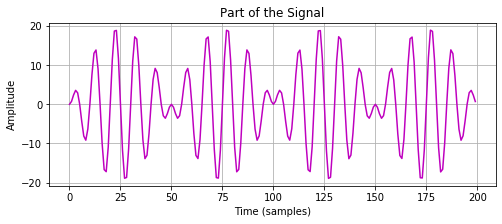

In [331]:
FundamentalFrequency = 1000
SignalFrequency      = 100
SamplingFrequency    = 10000

# Amplitude of carrier (fundamental?)
#
A = 10

# Sampling period, number of seconds to synthesize and time axis (samples)
#
SamplingPeriod = 1./ SamplingFrequency
T  = 1
TimeAxis = np.linspace(0, T, int(T/SamplingPeriod)).reshape([-1,1]);

# Generate synthetic signal
#
ModulatingSignal =  2*np.sin(2*np.pi*SignalFrequency*TimeAxis)
Fundamental      = 10*np.sin(2*np.pi*FundamentalFrequency*TimeAxis)
signal           = Fundamental*ModulatingSignal
N = signal.shape[0]

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(signal[0:200], c="m")
ax.set_title("Part of the Signal")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)

[[ 0.23322535 -0.24304475 -0.44300602 -0.67929202  0.43986383 -0.18805056]]
(6, 1)


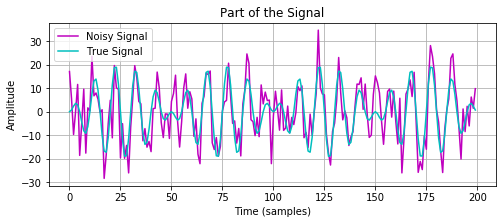

In [332]:
# White noise is Gaussian random numbers
#
WhiteNoise = 0.4*np.max(signal)*np.random.randn(N,1)
#Add noise to the signal
FilterOrder = 6
wTrue = np.random.randn(FilterOrder,1)
wTrue /= np.linalg.norm(wTrue)

# The true filter (what happens in the meduim)
#
print(wTrue.T)

# Generate coloured noise by filtering white noise
#
FilteredNoise = WhiteNoise.copy()
for n in (np.arange(FilterOrder+1,N-1)):
    PastValues  = WhiteNoise[n-FilterOrder-1:n-1,:]
    wnh = PastValues .T @ wTrue
    FilteredNoise[n] = wnh
print(PastValues.shape)
# Add noise to signal
#
NoisySignal = FilteredNoise + signal

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(NoisySignal[0:200,0], c="m",label="Noisy Signal")
ax.plot(signal[0:200,0], c="c", label="True Signal")
ax.set_title("Part of the Signal")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)
plt.legend()

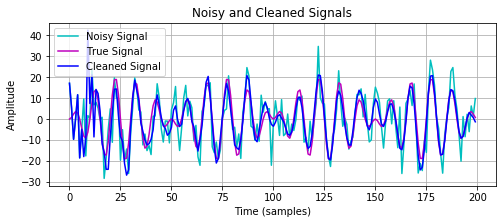

In [370]:
# Replace the filter with a Recursive Least Squares algorithm
# Lets assume we know the filter order: FilterOrder
#
InitialWeights = np.random.randn(FilterOrder,1)
CleanedSignal  = NoisySignal.copy()

# Learning Rate for LMS update
#

lam = 0.99
eps = 0.01
P = 1/eps * np.identity(FilterOrder)
# Initialize weights
#
Weights = InitialWeights 

# Save space to retain all updates to plot to observe convergence
#
AllWeights = np.zeros((FilterOrder,N))
for n in range(N):
    AllWeights[:,n] = Weights [:,0]
    
e = np.zeros(N)
# Adaptive noise canceller with LMS
#
for n in (np.arange(FilterOrder+1,N-1)):

    PastValues = WhiteNoise[n-FilterOrder-1:n-1,:]
    EstimatedNoise =  PastValues.T @ Weights 
    
    # Update is constant times error times input
    #
#     e[n] = NoisySignal[n] - EstimatedNoise[n]
    k = P @ PastValues / (lam + PastValues.T @ P @ PastValues)
    P = (P - k @ PastValues.T @ P) / lam
    Weights += k * (NoisySignal[n] - EstimatedNoise)
    
    # Save the weights
    #
    AllWeights[:,n] = Weights [:,0]

    # Estimated clean signal is difference between noisy signal and predicted noise
    #
    CleanedSignal[n,0] = NoisySignal[n,0] - EstimatedNoise 

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(NoisySignal[0:200], c="c", label="Noisy Signal")
ax.plot(signal[0:200], c="m", label="True Signal")
ax.plot(CleanedSignal[0:200], c="b", label = "Cleaned Signal")
ax.set_title("Noisy and Cleaned Signals")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)
plt.legend()
plt.savefig("RLS_filter.png")